# Case Study 2.2: Gender Wage Gap

Case Study 2.2: Gender Wage Gap
Instructor: Victor Chernuzkov
Activity Type: Optional 
Case Study Description: Estimate the difference in predicted wages between men and women with the same job characteristics.
Why this Case Study? Participants can pose an economic question and investigate that question using a linear regression model.
Self-Help Package Contents: 

The video that covers this case study is given in Module 2, Segment 1.6.

Self-help-package.zip

Codebook.txt contains the description of worker job-relevant characteristics.
pay.discrimination.Rdata: the CPS (2012) data on wages and job-relevant worker characteristics, such as experience exp, gender, education.
Regression1.6.CaseStudy.R estimates gender wage gap, i.e., difference in predicted wages between men and women with same job-relevant characteristics. The gap is estimated in two steps: (1) residualizing the outcome (wages) and covariate of interest (gender) (taking residuals from corresponding regressions on worker characteristics), and (2) computing the correlation between residualised wages on residualised gender. Both linear and quadratic specifications are tried at residualizing step.
Regression.1.6.pdf is the set of slides that describes the estimation technique and present the results.
.Rhistory
Time Required: The time required to do this activity varies depending on your experience in the required programming background. We suggest planning somewhere between 1 & 3 hours. Remember, this is an optional activity for participants looking for hands-on experience.

In [2]:
from IPython.display import HTML, display


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/Users/claudiogimenestoledo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Getting Data

In [3]:
# Codebook for pay.discrimination.Rdata dataset.
# 05/09/2016

# The dataset is compiled from 2012 Current Population Survey, March Supplement.
# The sample includes never-married individuals who are either collage or high school
# graduates or have some collage education.

# The dataset contains the following variables:

# wage   : weekly wage
# female : female dummy
# cg     : collage Graduate Dummy
# sc     : some collage dummy
# hsg    : High School graduate dummy
# mw     : midwest dummy
# so     : south dummy
# we     : west dummy
# ne     : northeast dummy
# exp1   : experience(year)
# exp2   : experience squared
# exp3   : experinence cubed

#wage ~ female + sc+ cg+ mw + so + we + exp1 + exp2 + exp3 (features used in the referece program in R)
# >ignoring the following ones: hsg, ne


In [4]:
dataset = pd.read_csv('data.csv')
dataset.head()

,female,cg,sc,hsg,mw,so,we,ne,exp1,exp2,exp3,wage
0,0,0,0,1,0,0,0,1,33.0,10.89,35.937,11.659091
1,0,1,0,0,0,0,0,1,27.0,7.29,19.683,12.825000
2,0,0,1,0,0,0,0,1,13.0,1.69,2.197,5.777027
3,0,1,0,0,0,0,0,1,2.0,0.04,0.008,12.468750
4,1,1,0,0,0,0,0,1,15.0,2.25,3.375,18.525000


In [5]:
dataset_female = dataset[dataset['female'] == True]
dataset_male = dataset[dataset['female'] != True]
display(dataset_female)
display(dataset_male)

,female,cg,sc,hsg,mw,so,we,ne,exp1,exp2,exp3,wage
4,1,1,0,0,0,0,0,1,15.0,2.2500,3.375000,18.525000
6,1,0,1,0,0,0,0,1,6.0,0.3600,0.216000,7.775199
11,1,1,0,0,0,0,0,1,4.0,0.1600,0.064000,15.750000
13,1,0,1,0,0,0,0,1,4.5,0.2025,0.091125,14.250000
14,1,0,0,1,0,0,0,1,15.0,2.2500,3.375000,19.593750
...,...,...,...,...,...,...,...,...,...,...,...,...
3825,1,0,1,0,0,0,1,0,31.5,9.9225,31.255875,16.031250
3826,1,1,0,0,0,0,1,0,11.0,1.2100,1.331000,23.156250
3830,1,1,0,0,0,0,1,0,3.0,0.0900,0.027000,17.812500
3832,1,0,1,0,0,0,1,0,18.0,3.2400,5.832000,18.525000


,female,cg,sc,hsg,mw,so,we,ne,exp1,exp2,exp3,wage
0,0,0,0,1,0,0,0,1,33.0,10.8900,35.937000,11.659091
1,0,1,0,0,0,0,0,1,27.0,7.2900,19.683000,12.825000
2,0,0,1,0,0,0,0,1,13.0,1.6900,2.197000,5.777027
3,0,1,0,0,0,0,0,1,2.0,0.0400,0.008000,12.468750
5,0,0,1,0,0,0,0,1,6.5,0.4225,0.274625,11.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
3827,0,0,0,1,0,0,1,0,20.0,4.0000,8.000000,8.459275
3828,0,0,0,1,0,0,1,0,15.0,2.2500,3.375000,8.906250
3829,0,0,1,0,0,0,1,0,7.5,0.5625,0.421875,12.112500
3831,0,0,0,1,0,0,1,0,14.0,1.9600,2.744000,12.825000


## Exploring the data: Descriptive statistics and visualizing


In [6]:
#Descriptive statistics

print ('## FEMALE DATASET ## ')
display(dataset_female.describe())
print ('## MALE DATASET ## ')
display(dataset_male.describe())

## FEMALE DATASET ## 


,female,cg,sc,hsg,mw,so,we,ne,exp1,exp2,exp3,wage
count,1603.0,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000
mean,1.0,0.406114,0.354336,0.239551,0.291329,0.255147,0.198378,0.255147,13.037118,2.449453,5.599297,14.720058
std,0.0,0.491259,0.478461,0.426943,0.454516,0.436080,0.398903,0.436080,8.661733,2.872428,8.834364,14.955865
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.040000,0.008000,0.004275
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.360000,0.216000,9.006563
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,1.210000,1.331000,12.468750
75%,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,19.000000,3.610000,6.859000,17.100000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,12.250000,42.875000,348.333017


## MALE DATASET ## 


,female,cg,sc,hsg,mw,so,we,ne,exp1,exp2,exp3,wage
count,2232.0,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,0.0,0.354839,0.301971,0.343190,0.284946,0.235215,0.221326,0.258513,13.580197,2.586588,5.964938,16.117458
std,0.0,0.478572,0.459216,0.474881,0.451490,0.424228,0.415233,0.437915,8.618025,2.936934,9.172277,12.353569
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.040000,0.008000,0.014250
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.490000,0.343000,9.908741
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,1.210000,1.331000,13.537500
75%,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,4.000000,8.000000,18.889347
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,12.250000,42.875000,274.038462


In [7]:

# again, invoke statsmodel's formula API using the below syntax
ols_model = ols("""wage ~ female + sc+ cg+ mw + so + we + exp1 + exp2 + exp3""", data=dataset).fit()
# summarize our model
ols_model_summary = ols_model.summary()
HTML(
(ols_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

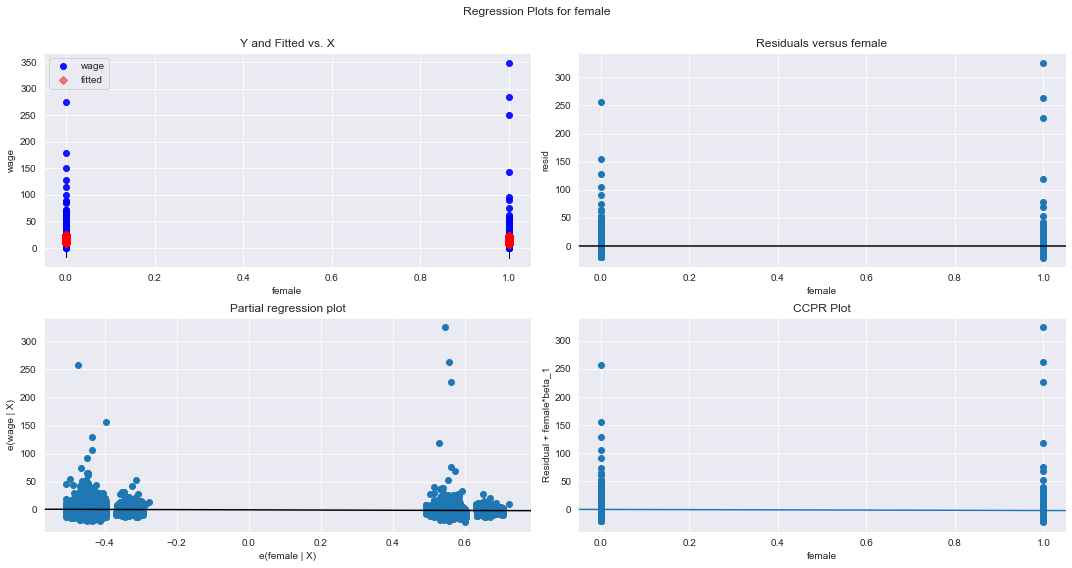

In [8]:
# This produces our four regression plots for female

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(ols_model, "female", fig=fig)

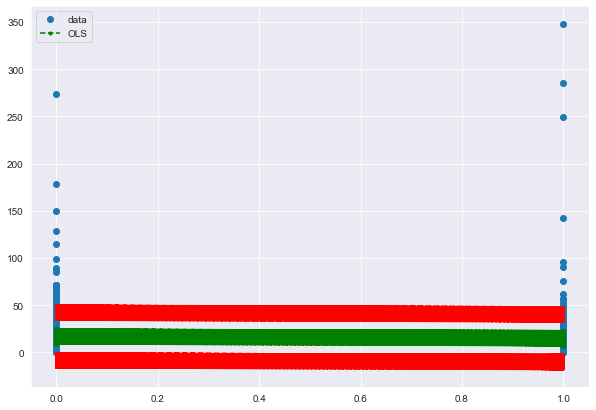

In [9]:
# predictor variable (x) and dependent variable (y)
x = dataset[['female']]
y = dataset[['wage']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(ols_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, ols_model.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');

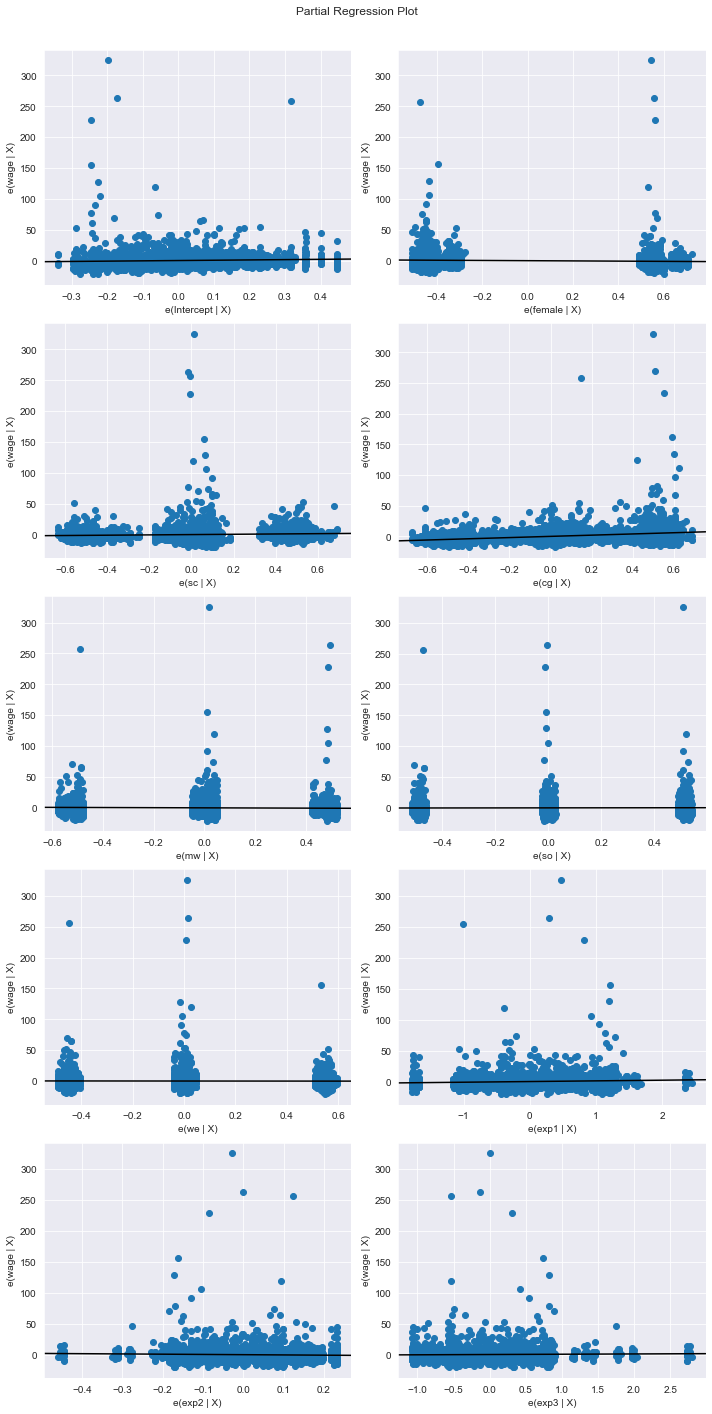

In [10]:
# this produces our six partial regression plots
fig = plt.figure(figsize=(10,20))
fig = sm.graphics.plot_partregress_grid(ols_model, fig=fig)

In [11]:
# Linear regression of y (outcome) on covariates
ols_model_outcome = ols("""wage ~  np.power((sc+ cg+ mw + so + we + exp1 + exp2 + exp3), 2)""", data=dataset).fit()

# Linear regression of d (treatment) on covariates
ols_model_treatment = ols("""female ~  np.power((sc+ cg+ mw + so + we + exp1 + exp2 + exp3), 2)""", data=dataset).fit()



In [12]:
# regress residuals one onether to get result from partialled out regression
resid_regression = sm.OLS(ols_model_outcome.resid, ols_model_treatment.resid).fit()

In [13]:
resid_regression_summary = resid_regression.summary()
HTML(
(resid_regression_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

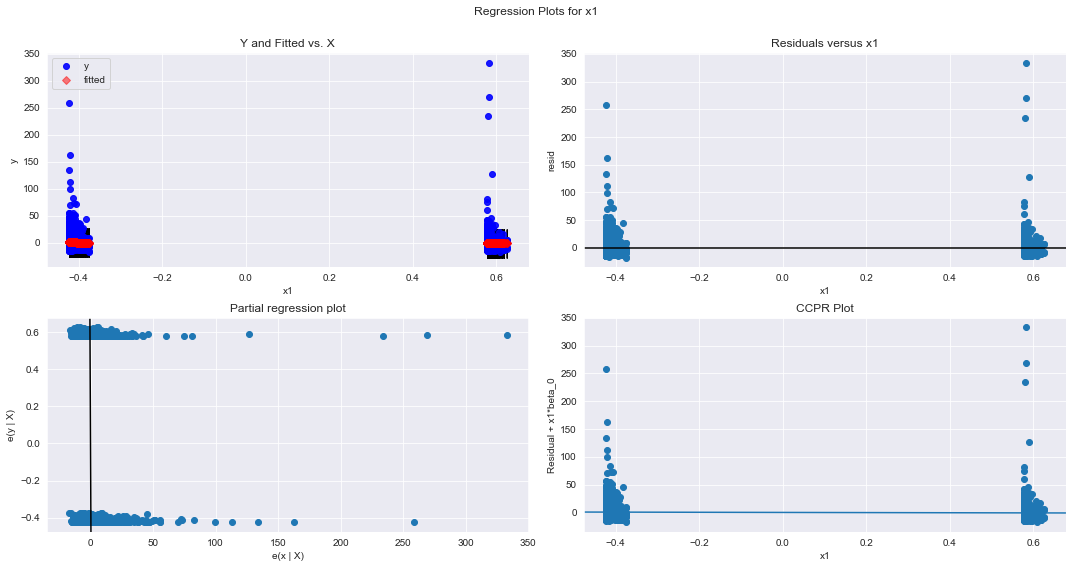

In [15]:
# This produces our four regression plots for female

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(resid_regression, "x1", fig=fig)

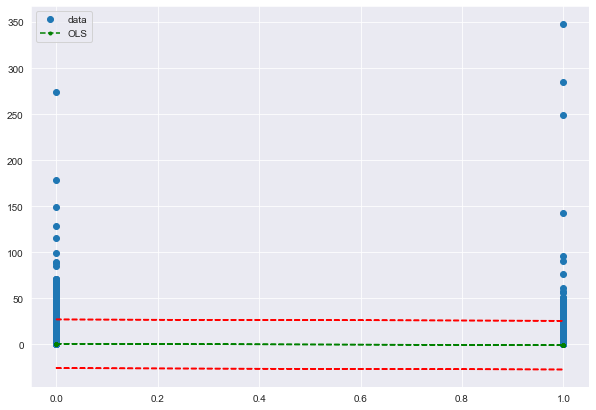

In [18]:
# predictor variable (x) and dependent variable (y)
x = dataset[['female']]
y = dataset[['wage']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(resid_regression)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, resid_regression.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');